In [16]:
import tensorflow as tf 
import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os

In [17]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

PATH = os.path.join(os.path.dirname("train_image/"))
train_dir = os.path.join(PATH)

PATHTEST = os.path.join(os.path.dirname("test_image/"))
validation_dir = os.path.join(PATHTEST)

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2299 files belonging to 2 classes.


In [19]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 443 files belonging to 2 classes.


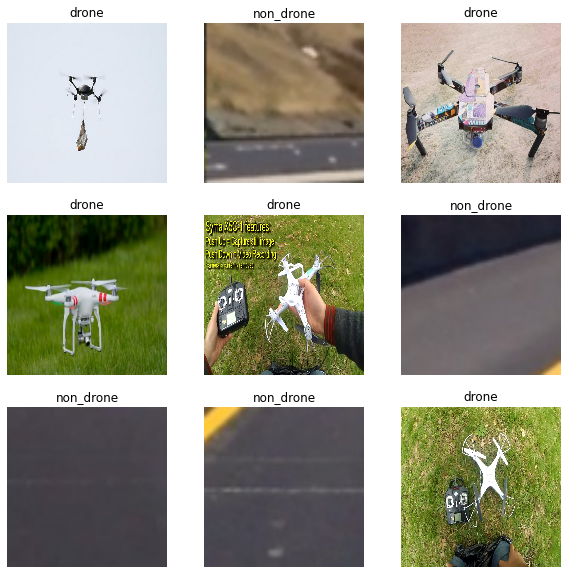

In [20]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [22]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 2


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [27]:
base_model.trainable = False

In [28]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [31]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
len(model.trainable_variables)

2

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 12s 482ms/step - loss: 0.7875 - accuracy: 0.6887


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.69


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
72/72 [==============================] - 53s 634ms/step - loss: 0.7923 - accuracy: 0.4959 - val_loss: 0.5189 - val_accuracy: 0.8285
Epoch 2/10
72/72 [==============================] - 45s 617ms/step - loss: 0.3705 - accuracy: 0.8351 - val_loss: 0.3017 - val_accuracy: 0.9578
Epoch 3/10
72/72 [==============================] - 44s 596ms/step - loss: 0.2188 - accuracy: 0.9430 - val_loss: 0.1995 - val_accuracy: 0.9815
Epoch 4/10
72/72 [==============================] - 49s 661ms/step - loss: 0.1408 - accuracy: 0.9774 - val_loss: 0.1529 - val_accuracy: 0.9921
Epoch 5/10
72/72 [==============================] - 49s 663ms/step - loss: 0.1064 - accuracy: 0.9861 - val_loss: 0.1093 - val_accuracy: 0.9974
Epoch 6/10
72/72 [==============================] - 47s 631ms/step - loss: 0.0823 - accuracy: 0.9896 - val_loss: 0.0893 - val_accuracy: 0.9947
Epoch 7/10
72/72 [==============================] - 50s 672ms/step - loss: 0.0648 - accuracy: 0.9917 - val_loss: 0.0879 - val_accuracy: 0.9921

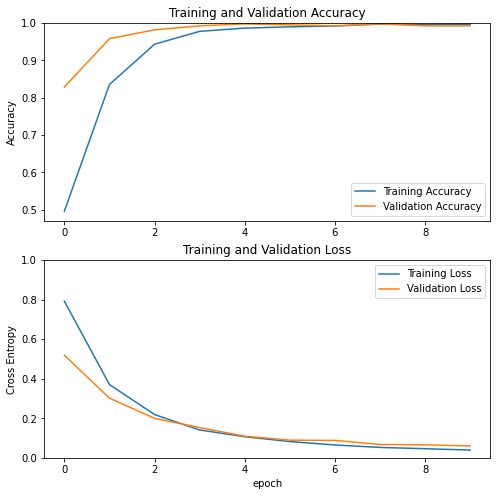

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [41]:
len(model.trainable_variables)

56

In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
72/72 [==============================] - 81s 940ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0130 - val_accuracy: 0.9974
Epoch 11/20
72/72 [==============================] - 67s 911ms/step - loss: 2.4876e-04 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9974
Epoch 12/20
72/72 [==============================] - 65s 883ms/step - loss: 2.2270e-05 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9974
Epoch 13/20
72/72 [==============================] - 66s 896ms/step - loss: 9.5725e-06 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9974
Epoch 14/20
72/72 [==============================] - 67s 906ms/step - loss: 3.6536e-07 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9974
Epoch 15/20
72/72 [==============================] - 64s 869ms/step - loss: 1.0861e-07 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9974
Epoch 16/20
72/72 [==============================] - 63s 855ms/step - loss: 1.0592e-06 - accuracy: 1.0000 - val_loss

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

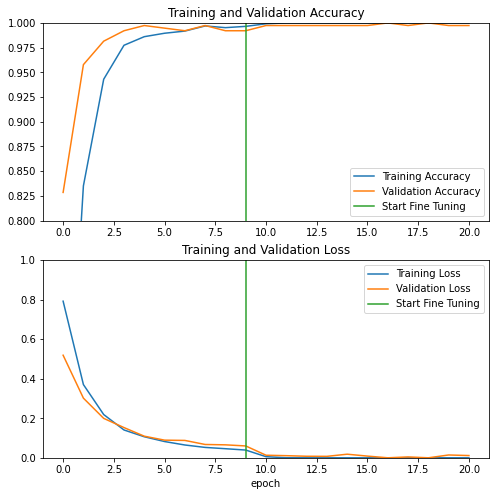

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 4s 571ms/step - loss: 8.5679e-07 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0]
Labels:
 [0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0]


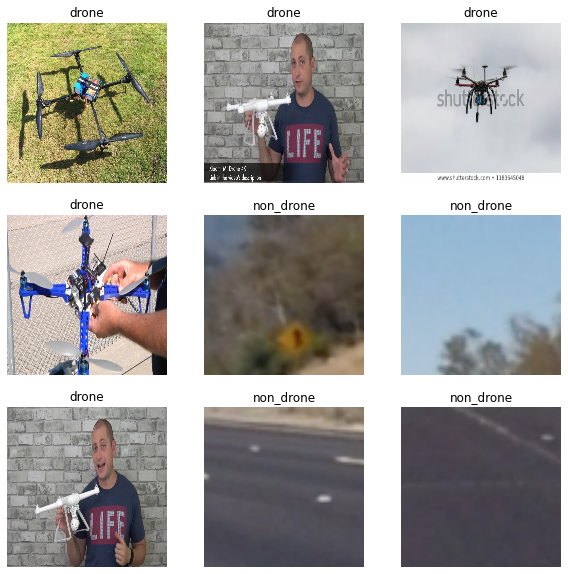

In [50]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [5]:
from os import walk

mypath = 'annotation/train_annotation/annotation'
filenames = next(walk(mypath), (None, None, []))[2] 

In [6]:
print(len(filenames))

795


In [1]:
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
from PIL import Image

In [11]:
file = 'annotation/train_annotation/annotation/foto00088.xml'
tree = ET.parse(file)
root = tree.getroot()
name = root.find("filename").text
labels = [root[6][4][0].text, root[6][4][1].text, root[6][4][2].text, root[6][4][3].text]

In [13]:
print(name,labels)

foto00088.png ['496', '261', '737', '411']
